In [ ]:
!pip install feedparser
!pip install newspaper3k
!pip install gnews
!pip install lxml_html_clean

In [10]:
import re, os, requests, json, yfinance as yf
from datetime import datetime, timedelta
from getpass import getpass
from langchain.llms.base import LLM
import matplotlib.pyplot as plt
from langchain.agents import initialize_agent, Tool, AgentType
from gnews import GNews
import spacy
import os, requests
from getpass import getpass
from langchain.llms.base import LLM
import math

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

Configurations

In [11]:
TRUSTED_SOURCES = [
    "reuters", "bloomberg", "wsj", "cnbc", "financial times", "ft.com",
    "the wall street journal", "the financial times", "the economist", "the new york times",
    "the washington post", "the guardian", "the times", "the telegraph",
    "cnn business", "bbc business", "nbc business", "cbs business", "abc business",
    "the street", "investopedia", "fool.com",
    "marketwatch", "barrons", "economist", "forbes", "morningstar", "yahoo finance",
    "zacks", "seekingalpha", "investopedia", "fool", "thestreet", "nasdaq",
    "bbc", "guardian", "nytimes", "washingtonpost", "time", "npr",
    "abc news", "nbc news", "cbs news", "usa today", "politico", "axios",
    "business insider", "fortune", "fastcompany", "wired", "venturebeat", "protocol",
    "associated press", "apnews", "upi", "businesswire", "prnewswire", "globenewswire",
    "marketwired", "thestockmarketwire", "securities and exchange commission",
    "techcrunch", "arstechnica", "fiercebiotech", "fiercepharma", "medscape",
    "biopharmadive", "supplychaindive", "retaildive", "cfo.com",
    "nikkei", "asiafinancial", "scmp", "south china morning post",
    "the hindu business line", "economic times", "livemint",
    "afr.com", "the australian financial review", "globe and mail", "canadianbusiness",
    "les echos", "handelsblatt", "deutsche welle", "elpais", "expansion",
    "benzinga", "kiplinger", "marketscreener", "tradingeconomics", "fxstreet",
    "cointelegraph", "coindesk", "cryptoslate", "etftrends", "etfdailynews"
]


KEY_TERMS = {"earnings", "sec filing", "guidance", "revenue", "acquisition", "partnership", "ceo", "cfo"}
GEMINI_MODEL = "gemini-2.5-pro"

Utilities

In [4]:
def safe_json_parse(raw: str):
    try:
        return json.loads(raw)
    except:
        cleaned = raw.strip()
        cleaned = re.sub(r"^```(json)?", "", cleaned)
        cleaned = re.sub(r"```$", "", cleaned)
        cleaned = cleaned.strip()

        try:
            return json.loads(cleaned)
        except:
            match = re.search(r"\{.*\}", raw, re.DOTALL)
            if match:
                return json.loads(match.group(0))
            raise ValueError(f"Could not parse JSON:\n{raw}")

In [12]:
# Display the analysis plan in a readable format
def display_plan(plan_json: str):
    try:
        plan = json.loads(plan_json) if isinstance(plan_json, str) else plan_json
    except Exception as e:
        print("Could not parse plan JSON:", e)
        print(plan_json)
        return

    print("\n Analysis Plan")
    print("="*60)

    steps = plan.get("plan", plan)  # handle both wrapped or plain JSON
    for step in steps:
        num = step.get("step_number", "?")
        action = step.get("action", "")
        tool = step.get("tool_needed", "")
        desc = step.get("description", "")
        print(f" Step {num}: {action}")
        print(f" Tool   : {tool}")
        print(f" Detail : {desc}\n")

    print("="*60)

# Function to display the report in a readable format
def display_report(data: dict, hist_prices=None):
    print("="*60)
    print(f"Financial Report: {data['symbol']}")
    print("="*60)

    # Price Analysis
    print("\n Price Analysis")
    pa = data["price_analysis"]
    print(f"   Current Price      : {pa['current_price']}")
    print(f"   30-Day Moving Avg  : {pa['30d_moving_avg']}")
    print(f"   Trend              : {pa['trend']}")

    # News Analysis
    print("\n News Analysis")
    na = data["news_analysis"]
    print(f"   Sentiment     : {na['sentiment']}")
    print(f"   Classification: {na['classification']}")
    print(f"   Summary       : {na['Summary']}")

    # Earnings Analysis
    print("\n Earnings Analysis")
    ea = data["earnings_analysis"]
    print(f"   EPS       : {ea['EPS']}")
    print(f"   Revenue   : {ea['Revenue']}")
    print(f"   Guidance  : {ea['Guidance']}")
    print(f"   Summary   : {ea['Summary']}")

    print("\n" + "="*60)

        # Chart 1: Price trend
    if hist_prices is not None and not hist_prices.empty:
        plt.figure(figsize=(10,5))
        plt.plot(hist_prices.index, hist_prices["Close"], label="Close Price", linewidth=2)
        plt.axhline(y=float(pa["30d_moving_avg"]), color="red", linestyle="--", label="30D Moving Avg")
        plt.title(f"{data['symbol']} - Last 30 Days Price Trend")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Chart 2: Sentiment distribution
    sentiments = [na["sentiment"]]
    sentiment_counts = {s: sentiments.count(s) for s in set(sentiments)}

    plt.figure(figsize=(6,4))
    plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=["green","red","gray"])
    plt.title("Sentiment Distribution")
    plt.ylabel("Count")
    plt.show()

Finance Tools:
Retrives Stock Prices Data from Yahho Finanace

In [5]:
def get_price_data(ticker: str):
  stock = yf.Ticker(ticker)
  hist = stock.history(period="30d")
  if hist.empty:
      return {"current_price": None, "30d_moving_avg": None, "trend": "unknown"}

  current_price = float(hist["Close"].iloc[-1])
  moving_avg = float(hist["Close"].mean())
  trend = "up" if current_price > moving_avg else "down"

  return {
      "current_price": f"{current_price:.2f}",
      "30d_moving_avg": f"{moving_avg:.2f}",
      "trend": trend,
  }

def get_eps_revenue(ticker: str):
  t = yf.Ticker(ticker)

  cal = t.get_earnings_dates(limit=8).sort_index()
  eps = float(cal[cal["Reported EPS"].notna()].iloc[-1]["Reported EPS"])
  revenue = int(t.quarterly_income_stmt.loc["Total Revenue"].iloc[0])

  return {
      "EPS": f"{eps:.2f} USD/share",
      "Revenue": f"${revenue:,.0f} (USD)"
  }

News Tools

In [6]:
def fetch_news(ticker: str, max_articles: int = 1):
    google_news = GNews(language="en", country="US", period="90d", max_results=20)
    results = google_news.get_news(f"{ticker} stock")

    cutoff = datetime.now() - timedelta(days=90)
    articles = []

    for article in results:
        title = article.get("title", "")
        summary = article.get("description", "")
        publisher = article.get("publisher", {}).get("title", "")
        pub_date_str = article.get("published date", "")

        pub_date = None
        try:
            pub_date = datetime.strptime(pub_date_str, "%a, %d %b %Y %H:%M:%S %Z")
        except:
            pass

        if publisher.lower() not in TRUSTED_SOURCES:
            continue
        if pub_date < cutoff:
            continue

        articles.append({
            "title": title,
            "summary": summary,
            "publisher": publisher,
            "publishedAt": pub_date.isoformat(),
            "url": article.get("url", "")
        })

        if len(articles) >= max_articles:
            break

    return articles


def _aggregate_news(items: list[dict]) -> str:
    parts = []
    for i, it in enumerate(items, 1):
        title = it.get("title", "")
        summary = it.get("summary", "")
        parts.append(f"[{i}] {title}\n{summary}")
    return "\n\n---\n\n".join(parts).strip()


LLM Tools

In [7]:
# Gemini API wrapper
def call_gemini(prompt: str, model: str = "gemini-2.5-pro") -> str:
    url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:generateContent?key={os.getenv('GOOGLE_API_KEY')}"
    headers = {"Content-Type": "application/json"}
    payload = {"contents": [{"parts": [{"text": prompt}]}]}
    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()
    data = response.json()
    text = data["candidates"][0]["content"]["parts"][0]["text"]

    return text

# LangChain LLM wrapper
class GeminiLLM(LLM):
    def _call(self, prompt: str, stop=None) -> str:
        return call_gemini(prompt)
    @property
    def _identifying_params(self): return {"name": "GeminiLLM"}
    @property
    def _llm_type(self): return "custom_gemini"



def analyze_sentiment(text: str) -> str:
    return f"Sentiment: {'positive' if 'strong' in text else 'neutral'}"

tools = [
    Tool(name="FetchNews", func=fetch_news, description="Fetch recent news for a stock ticker"),
    Tool(name="SentimentAnalyzer", func=analyze_sentiment, description="Classify news as positive, neutral, or negative"),
]

llm = GeminiLLM()
sub_agent = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, handle_parsing_errors=True)

/tmp/ipython-input-3673690318.py:33: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  sub_agent = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, handle_parsing_errors=True)


Main Agent

In [8]:
class InvestmentResearchAgent:
    def __init__(self, ticker: str):
        self.ticker = ticker
        self.memory = []

    def plan_steps(self, context: str = ""):
        prompt = f"""
        You are a financial analyst. Given the stock ticker: {self.ticker} and context: {context},
        return a JSON-structured plan, where each step has:
          - step_number
          - action
          - tool_needed
          - description
        """
        raw = call_gemini(prompt)
        return safe_json_parse(raw)

    def prompt_chain(self, news_text: str):
        clean = news_text.strip()
        classification = self.route(clean)
        facts = call_gemini(f"Extract key financial metrics from this text:\n{clean}")
        summary = call_gemini(f"Summarize in 3 sentences and limit in 200 words:\n{facts}")
        return {"classification": classification, "summary": summary}

    def route(self, text: str):
        doc = nlp(text)
        ents = [(ent.text, ent.label_) for ent in doc.ents]

        orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
        persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
        money = [ent.text for ent in doc.ents if ent.label_ in ("MONEY", "PERCENT")]
        dates = [ent.text for ent in doc.ents if ent.label_ == "DATE"]

        if orgs and money:
            category = "earnings"
        elif len(orgs) >= 2:
            category = "merger/acquisition"
        elif persons and orgs:
            category = "executive news"
        else:
            category = "general"

        # call gemini for detailed analysis only one time
        analysis = call_gemini(f"Category: {category}\nNews:\n{text}\n\nProvide a detailed {category} analysis.")

        return {
            "category": category,
            "entities": ents,
            "analysis": analysis
        }

    def evaluate_and_refine(self, analysis_text: str) -> str:
      critique = call_gemini(
          "Critique the following financial analysis for accuracy, clarity, relevance, "
          "and actionability for investors:\n\n" + analysis_text
      )
      improved = call_gemini(
          f"Original analysis:\n{analysis_text}\n\nCritique:\n{critique}\n\n"
          "Rewrite the analysis applying all improvements. Return only the improved analysis."
      )
      return improved

    def remember(self, note: str): self.memory.append(note)
    def recall(self): return "\n".join(self.memory[-3:]) if self.memory else "No past memory."

      # orchestrator
    def run(self, context: str = "", max_articles: int = 5) -> dict:
        print("Plan:", self.plan_steps(context))

        # 1) fetch news
        items = fetch_news(self.ticker, max_articles=max_articles)

        price = get_price_data(self.ticker)
        eps_rev = get_eps_revenue(self.ticker)

        # 2) aggregate all articles into one text block
        combined_text = _aggregate_news(items)

        # 3) single-pass analysis on the aggregated text
        chained = self.prompt_chain(combined_text)    # {"classification": ..., "summary": ...}
        routed  = self.route(combined_text)           # {"category","entities","analysis"}
        refined = self.evaluate_and_refine(routed["analysis"])

        # 4) one overall sentiment on the combined text
        overall_sentiment = analyze_sentiment(combined_text)

        # 5) the summary from all news
        news_rows = {
            "sentiment": overall_sentiment,
            "classification": routed["category"],
            "Summary": refined,
        }

        # 6) ask LLM ONCE to fill ONLY earnings based on aggregate
        base = {
            "symbol": self.ticker,
            "price_analysis": price,
            "news_analysis": news_rows,
            "earnings_analysis": {
                "EPS": eps_rev["EPS"],
                "Revenue": eps_rev["Revenue"],
                "Guidance": "<number here>",
                "Summary": "<text here> - keep limit to 200 words"
            }
        }

        fill_prompt = f"""
    You are a financial analysis assistant.
    Using ONLY the AGGREGATED analysis below, fill the Summary and Guidance fields in earnings_analysis.
    Do not change price_analysis, news_analysis, EPS or Revenue.

    Aggregated classification: {routed['category']}
    Prompt-chain summary: {chained.get('summary','')}
    Aggregated refined analysis:
    {refined}

    JSON:
    {json.dumps(base, indent=2)}
    """
        filled = safe_json_parse(call_gemini(fill_prompt))
        earnings = filled.get("earnings_analysis", base["earnings_analysis"])

        return {
            "symbol": self.ticker,
            "price_analysis": price,
            "news_analysis": news_rows,
            "earnings_analysis": earnings,
        }


In [9]:
os.environ["GOOGLE_API_KEY"] = getpass("Enter your Google API key: ")

agent = InvestmentResearchAgent("AAPL")  # MSFT, NVDA, TSLA, etc.
result = agent.run()
print(json.dumps(result, indent=2))

Enter your Google API key: ··········
Plan: [{'step_number': 1, 'action': 'Gather Company Profile and Market Data', 'tool_needed': 'Financial Data Provider (e.g., Yahoo Finance, Bloomberg Terminal, Refinitiv Eikon)', 'description': 'Retrieve essential company information for AAPL, including its business description, industry classification, key executives, and current market data such as stock price, market capitalization, trading volume, and dividend yield.'}, {'step_number': 2, 'action': 'Analyze Historical Financial Statements', 'tool_needed': 'SEC Filings (EDGAR Database: 10-K, 10-Q)', 'description': "Download and review the last 3-5 years of AAPL's annual (10-K) and quarterly (10-Q) reports. Extract key data from the Income Statement, Balance Sheet, and Cash Flow Statement to analyze trends in revenue, net income, assets, liabilities, and cash flows from operations."}, {'step_number': 3, 'action': 'Perform Financial Ratio Analysis', 'tool_needed': 'Financial Modeling Software (e.g

Financial Report: AAPL

 Price Analysis
   Current Price      : 257.40
   30-Day Moving Avg  : 240.31
   Trend              : up

 News Analysis
   Sentiment     : Sentiment: neutral
   Classification: earnings
   Summary       : Based on the provided news headlines and applying the principles of a rigorous financial critique, here is an improved, data-driven earnings analysis for Apple (AAPL).

### **Apple (AAPL): Fundamental Analysis and Investment Thesis**

### Investment Thesis / Executive Summary

Apple's stock is trading near all-time highs, driven by a powerful market narrative centered on an anticipated AI-fueled iPhone "supercycle" and continued high-margin Services growth. While the bullish sentiment is strong, our analysis indicates that Apple's current valuation at over 30x forward earnings has already priced in a significant acceleration in growth. Current fundamentals, however, show low single-digit revenue growth and a reliance on share buybacks to boost EPS.

This creat

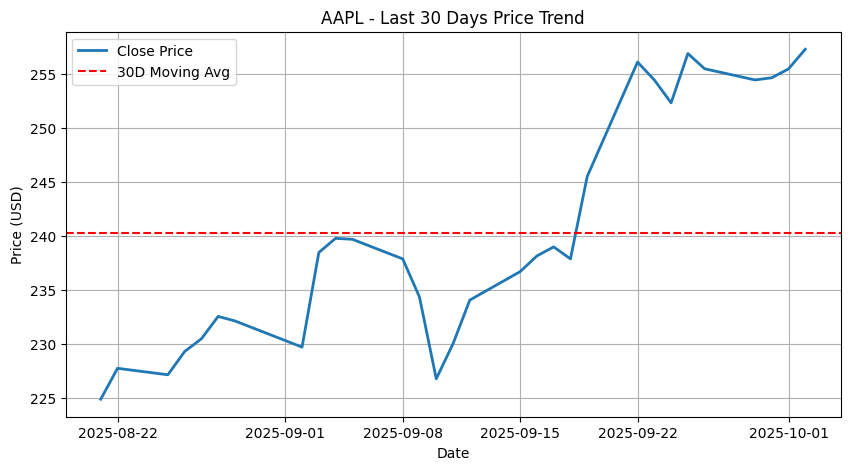

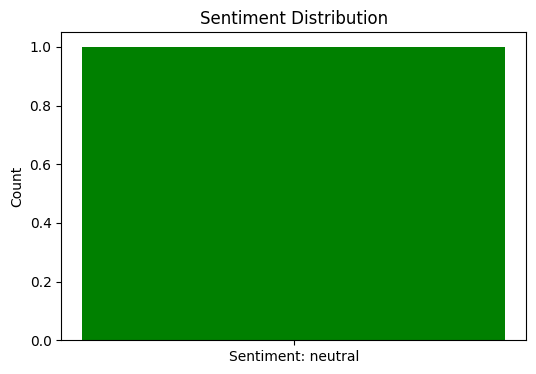

In [15]:
stock = yf.Ticker("AAPL")
hist = stock.history(period="30d") # Get last 30 days of price data

# Display output report
display_report(result, hist)